# 1.2.0 Heatmap Papers

In [1]:
import pandas as pd
import requests
from glob import glob
import json
from copy import deepcopy

In [2]:
from clustergrammer2 import net

In [3]:
all_files = glob('../markdown_files/*.md')
len(all_files)

97

### Load Altmetric Data

In [4]:
dict_altmetric = net.load_json_to_dict('../altmetric_data/altmetric_scores.json')

### Load Google Sheet Data

In [5]:
google_sheet_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRngfhDKqZUEhHuQY60n3Bh76gkMQKeOq6D7UYkSgt0KPP7rcCTE-PjMeWO1g1YlGVhBTAMJS6rn-pc/pub?gid=0&single=true&output=tsv'

In [6]:
r = requests.get(google_sheet_url)
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
TESTDATA = StringIO(r.text)
df = pd.read_csv(TESTDATA, sep="\t", index_col=0)
df.index.name = None

### Download Latest Preprints

In [7]:
url = 'https://connect.biorxiv.org/relate/collection_json.php?grp=181'

In [8]:
r = requests.get(url)

In [9]:
req_dict = json.loads(r.text)

In [10]:
stop_words = ["i","me","my","myself","we","us","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who","whom","whose","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","will","would","should","can","could","ought","i'm","you're","he's","she's","it's","we're","they're","i've","you've","we've","they've","i'd","you'd","he'd","she'd","we'd","they'd","i'll","you'll","he'll","she'll","we'll","they'll","isn't","aren't","wasn't","weren't","hasn't","haven't","hadn't","doesn't","don't","didn't","won't","wouldn't","shan't","shouldn't","can't","cannot","couldn't","mustn't","let's","that's","who's","what's","here's","there's","when's","where's","why's","how's","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through","during","before","after","above","below","to","from","up","upon","down","in","out","on","off","over","under","again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too","very","say","says","said","shall","2019","novel","patients","using","may","2019-ncov","2020"]
stop_words.extend(['2020,', 'conclusions', 'characteristics'])
stop_words.extend(['=', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [11]:
doi_words = {}
all_words = []
doi_titles = {}
arr_papers = req_dict['rels']
for inst_paper in arr_papers:

    # get words from abstract
    inst_words = [x.lower().replace(':','').replace(',','').replace('.','')
                           .replace('(', '').replace(')', '')
                           .replace('\n','').replace('\t','')
                           for x in inst_paper['rel_abs'].split()]
    
    inst_words = [x for x in inst_words if x not in stop_words]    
    
    # save words to dict 
    doi_words[inst_paper['rel_doi']] = sorted(list(set(inst_words)))
    
    doi_titles[inst_paper['rel_doi']] = inst_paper['rel_title']
    
    all_words.extend(inst_words)

In [12]:
ser_titles = pd.Series(doi_titles)
ser_titles.head()

10.1101/2020.04.02.20051441    Chaos theory applied to the outbreak of Covid-...
10.1101/2020.04.02.20051466    Predictions for COVID-19 outbreak in India usi...
10.1101/2020.04.02.20051680    COVID-19 epidemic: Power law spread and flatte...
10.1101/2020.04.03.20051821    Predicting clinical needs derived from the COV...
10.1101/2020.04.02.20051524    Evidence that higher temperatures are associat...
dtype: object

In [13]:
df_meta = pd.DataFrame(ser_titles, columns=['Title'])
df_meta.shape

(1254, 1)

### Add Paper Metadata

In [14]:
inst_paper.keys()

dict_keys(['rel_title', 'rel_doi', 'rel_link', 'rel_abs', 'rel_authors', 'rel_date', 'rel_site'])

In [15]:
for inst_paper in arr_papers:
    inst_doi = inst_paper['rel_doi']
    
    # date
    inst_date = inst_paper['rel_date'].split('-')
    df_meta.loc[inst_doi, 'date'] = float( inst_date[1] + '.' + inst_date[2])
    
    # altmetric score
    if inst_doi in dict_altmetric:
        df_meta.loc[inst_doi, 'altmetric'] = dict_altmetric[inst_doi]
    else:
        print('not found')
        df_meta.loc[inst_doi, 'altmetric'] = 0

In [16]:
ser_count = pd.Series(all_words).value_counts()
ser_count = ser_count[ser_count < len(arr_papers) * 0.75 ][ser_count > 5]
ser_count.shape

(3591,)

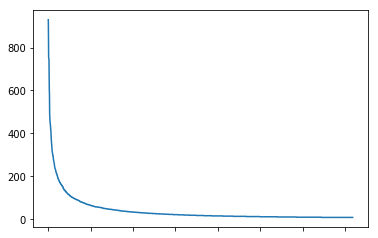

In [17]:
ser_count.plot()

In [18]:
top_words = ser_count.index.tolist()[:1000]

In [19]:
all_dois = sorted(list(doi_words.keys()))
len(all_dois)

1254

In [20]:
df_words = pd.DataFrame(0, index=top_words, columns=all_dois)

In [21]:
for inst_doi in all_dois:
    inst_words = list(set(doi_words[inst_doi]).intersection(top_words))
    df_words.loc[inst_words, inst_doi] = 1

### Add Column Categories

In [22]:
cols = df_words.columns.tolist()
new_cols = [(df_meta.loc[x, 'Title'][:50], 'Date: ' + str(df_meta.loc[x, 'date']), 'Altmetric: ' + str(df_meta.loc[x, 'altmetric']) )  for x in cols]
df_cat = deepcopy(df_words)
df_cat.columns = new_cols

In [23]:
net.load_df(df_cat)
net.filter_N_top(inst_rc='row', rank_type='sum', N_top=500)
# net.cluster(dist_type='jaccard')
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "results", "ini": 500, "clust": 477, "rank": 499, "rankvar": 49…

In [24]:
net.save_dict_to_json(net.viz, '../json_files/heatmap_2020-04-05.json')

### Words and Reviews

In [25]:
# words_list = []
# for inst_file in all_files:
#     f = open(inst_file, 'r')
#     lines = f.readlines()
#     f.close()
    
#     for inst_line in lines:
#         inst_line = inst_line.lower()
            
#         inst_words = inst_line.split(' ')
#         inst_words = [x for x in inst_words if '*' not in x]
#         words_list.extend(inst_words)

In [26]:
# pd.Series(words_list).value_counts().head(50)